<center><h1>Thai_Khang_HW2</h1></center>
<br>
<br>

Name: Khang Thai
<br>
Github Username: kunfupen
<br>
USC ID: 5721113147

## 1. Combined Cycle Power Plant Data Set

### (a) Download Data

Package imports

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsRegressor
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split


Get the Cycle Power Plant Data Set

In [2]:
data = pd.read_excel('CCPP/Folds5x2_pp.xlsx')
data.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


### (b) Exploring the data

#### i. rows and columns

In [3]:
print(f"Rows: {data.shape[0]}")
print(f"Columns: {data.shape[1]}")
print(data.head())
print("Rows represent individual power plant measurements under differnt operating conditions.")
print("Columns represent different operating conditions")

Rows: 9568
Columns: 5
      AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11  39.40  1012.16  92.14  488.56
3  20.86  57.32  1010.24  76.64  446.48
4  10.82  37.50  1009.23  96.62  473.90
Rows represent individual power plant measurements under differnt operating conditions.
Columns represent different operating conditions


#### ii. pairwise scatterplots of all the varianbles

<Figure size 1200x1000 with 0 Axes>

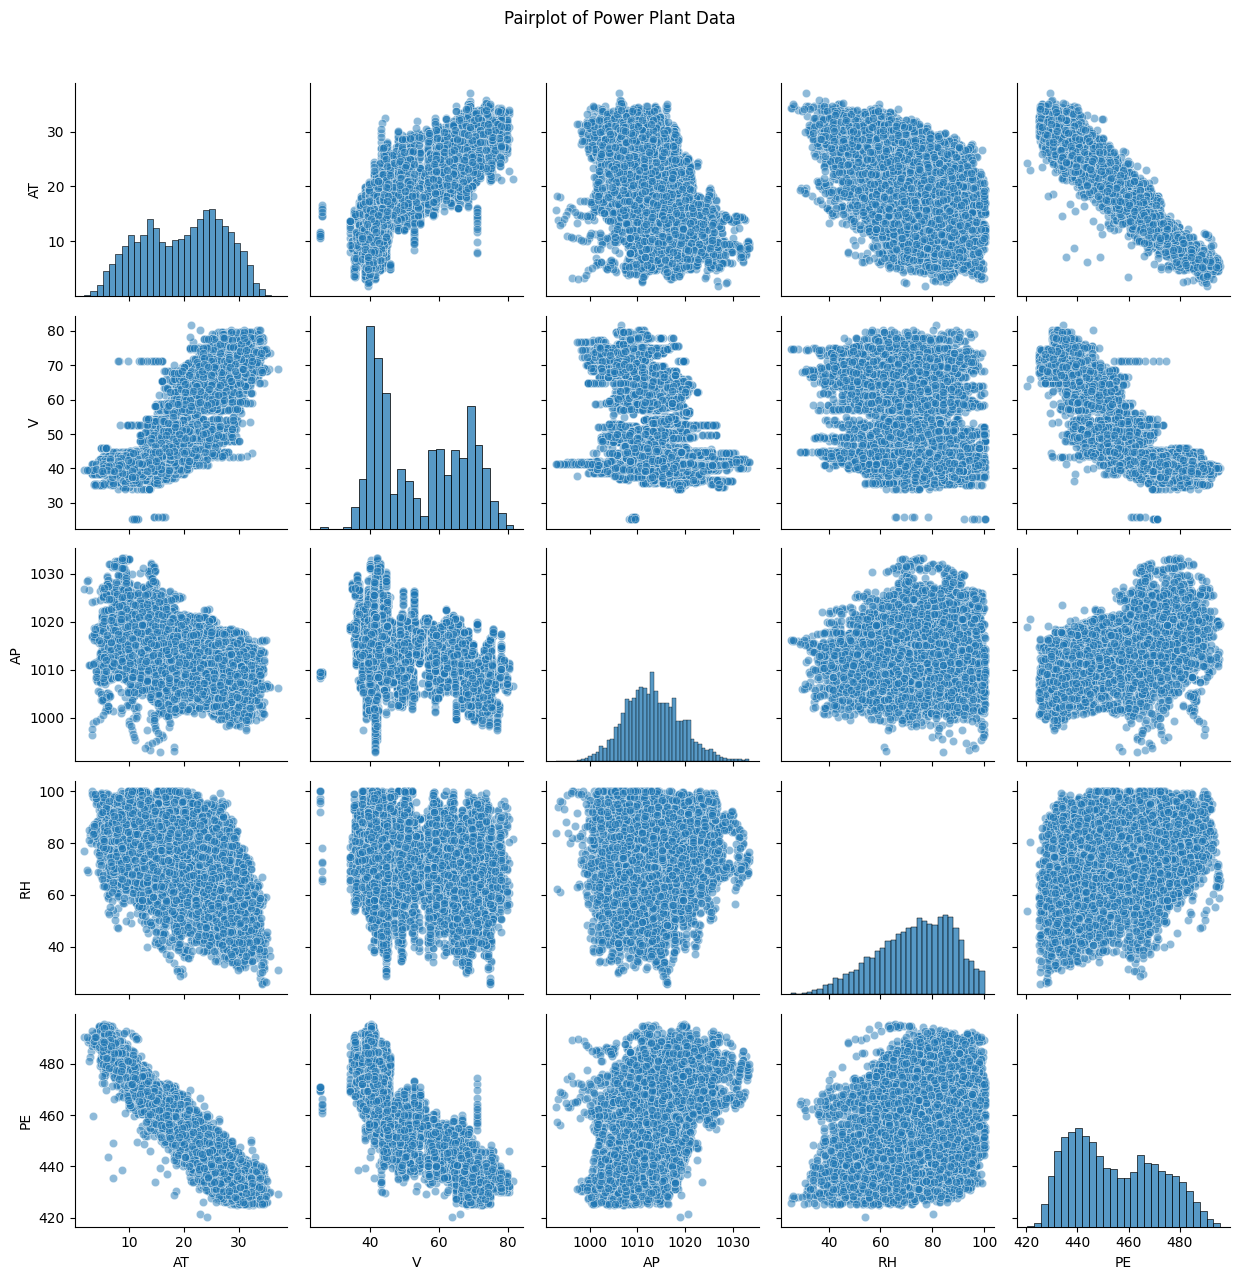

Temerature and Exhaust Vacuum show a strong negative correlation with the target variable (PE).
Ambient Pressure and Relative Humidity show weaker correlations with PE.


In [4]:
plt.figure(figsize=(12, 10))
sns.pairplot(data, diag_kind='hist',plot_kws={'alpha': 0.5})
plt.suptitle('Pairplot of Power Plant Data', y=1.02)
plt.tight_layout()
plt.show()

print("Temerature and Exhaust Vacuum show a strong negative correlation with the target variable (PE).")
print("Ambient Pressure and Relative Humidity show weaker correlations with PE.")

#### iii. mean, the median, range, first and third quartiles, and interquartile ranges

In [5]:
table = data.agg(['mean', 'median', 'min', 'max',
                  lambda x: x.quantile(0.25),
                  lambda x: x.quantile(0.75),
                  lambda x: x.max() - x.min(),
                  lambda x: x.quantile(0.75) - x.quantile(0.25)])
table.index = ['Mean', 'Median', 'Min', 'Max', 'Q1', 'Q3', 'Range', 'IQR']
print(table)


               AT          V           AP          RH          PE
Mean    19.651231  54.305804  1013.259078   73.308978  454.365009
Median  20.345000  52.080000  1012.940000   74.975000  451.550000
Min      1.810000  25.360000   992.890000   25.560000  420.260000
Max     37.110000  81.560000  1033.300000  100.160000  495.760000
Q1      13.510000  41.740000  1009.100000   63.327500  439.750000
Q3      25.720000  66.540000  1017.260000   84.830000  468.430000
Range   35.300000  56.200000    40.410000   74.600000   75.500000
IQR     12.210000  24.800000     8.160000   21.502500   28.680000


### (c) Simple Linear Regression

AT: PE = 497.03 + -2.17*AT
  R-squared: 89.8948, p-value: 0.0000e+00
V: PE = 517.80 + -1.17*V
  R-squared: 75.6518, p-value: 0.0000e+00
AP: PE = -1055.26 + 1.49*AP
  R-squared: 26.8769, p-value: 0.0000e+00
RH: PE = 420.96 + 0.46*RH
  R-squared: 15.1939, p-value: 0.0000e+00
All predictors show statistically significant associations with power output (p < 0.001)


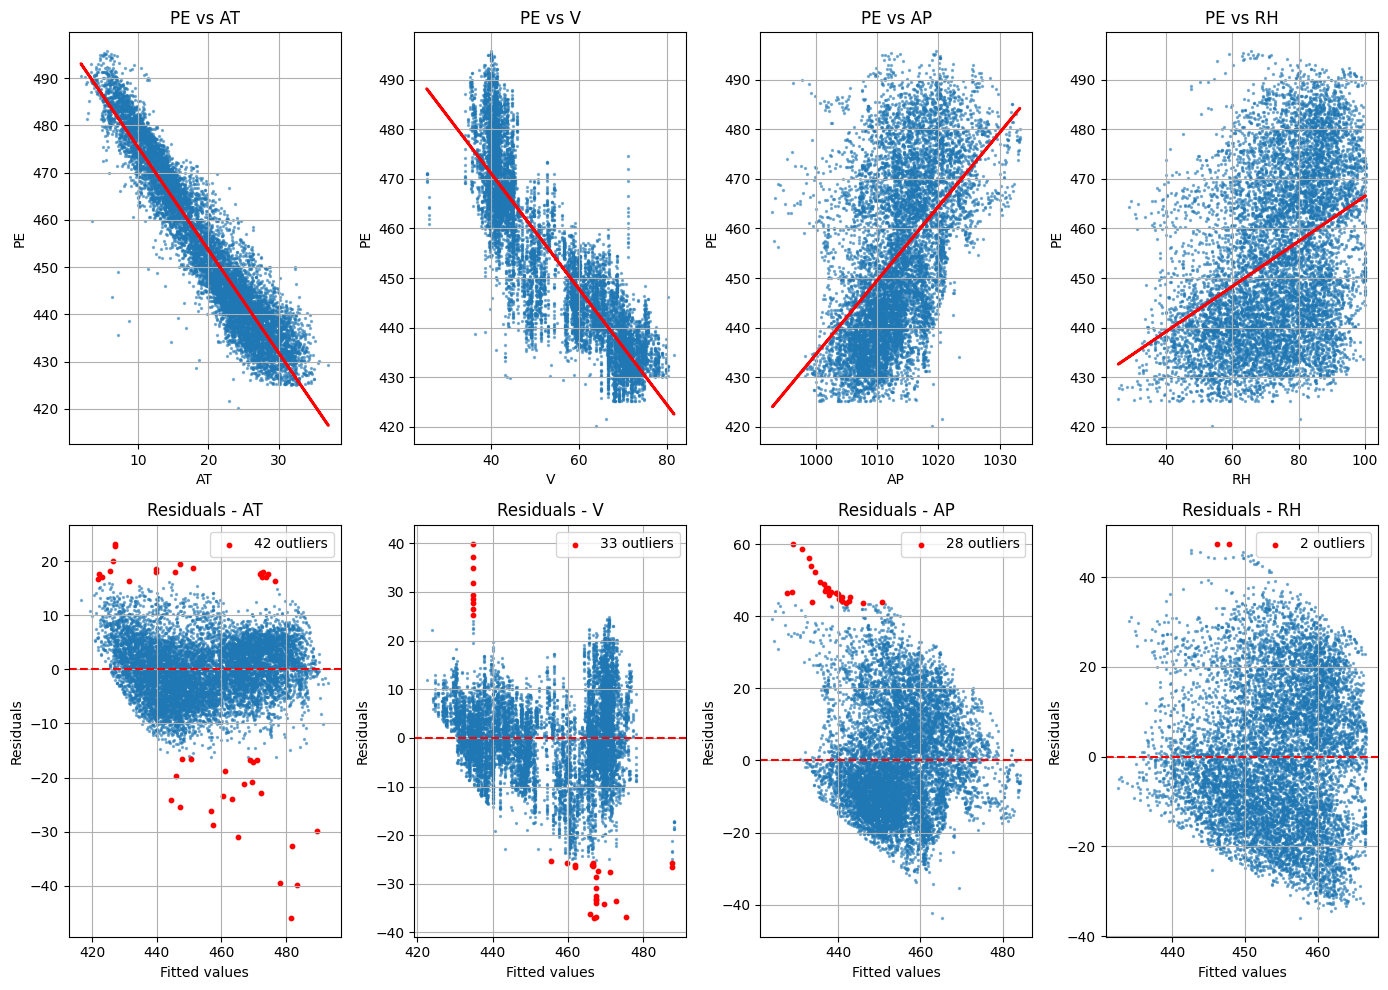

In [6]:
predictors = data.columns[:-1]
response = data.columns[-1]

reg_res = {}
for predictor in predictors:
    model = LinearRegression()
    model.fit(data[[predictor]], data[response])
    
    y_pred = model.predict(data[[predictor]])
    r2 = r2_score(data[response], y_pred)

    slope, intercept, r_value, p_value, std_err = stats.linregress(data[predictor], data[response])
    residuals = data[response] - y_pred

    reg_res[predictor] = {
        'predictions': y_pred,
        'residuals': residuals,
        'r2' : r2,
        'model' : model
    }

    print(f"{predictor}: {response} = {model.intercept_:.2f} + {model.coef_[0]:.2f}*{predictor}")
    print(f"  R-squared: {r2*100:.4f}, p-value: {p_value:.4e}")

print("All predictors show statistically significant associations with power output (p < 0.001)")

fig, axes = plt.subplots(2, 4, figsize=(14, 10))

for i, predictor in enumerate(predictors):

    y_pred = reg_res[predictor]['predictions']
    residuals = reg_res[predictor]['residuals']
    r2 = reg_res[predictor]['r2']

    ax1 = axes[0, i]
    ax1.scatter(data[predictor], data[response], alpha=0.5, s=2)
    ax1.plot(data[predictor], y_pred, color='red', linewidth=2)
    ax1.set_xlabel(predictor)
    ax1.set_ylabel(response)
    ax1.set_title(f'{response} vs {predictor}')
    ax1.grid(True)
    
    ax2 = axes[1, i]
    ax2.scatter(y_pred, residuals, alpha = 0.5, s = 2)
    ax2.axhline(y=0, color = 'red', linestyle = '--')
    
    std_residual = np.abs(residuals) / np.std(residuals)
    outliers = std_residual > 3
    if np.sum(outliers) > 0:
        ax2.scatter(y_pred[outliers], residuals[outliers], color='red', s=10, label=f'{np.sum(outliers)} outliers')
        ax2.legend()
    
    ax2.set_xlabel('Fitted values')
    ax2.set_ylabel('Residuals')
    ax2.set_title(f'Residuals - {predictor}')
    ax2.grid(True)

plt.tight_layout()
plt.show()

### (d) Multiple Regression

In [7]:
mult_model = LinearRegression()
mult_model.fit(data[predictors], data[response])

x = data[predictors]
x_with_const = sm.add_constant(x)
y = data[response]

model_sm = sm.OLS(y, x_with_const).fit()
print(model_sm.summary())

print("All predictors reject the null hypothesis H_0: B_j = 0")


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Wed, 24 Sep 2025   Prob (F-statistic):               0.00
Time:                        15:58:20   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.6093      9.749     46.634      0.0

### (e) 1c Compare to 1d

Coefficient Comparison:
Predictor       Simple Coef          Simple R2            Mult Coef            Change
AT              -2.171319958517795   0.8989475964148236   -1.9775131066353953  0.19380685188239966
V               -1.1681351265557085  0.7565177870683979   -0.23391642258249945 0.934218703973209
AP              1.4898716733991146   0.2687686564110675   0.06208294378085644  -1.4277887296182583
RH              0.45565010226298025  0.15193944023117578  -0.15805410291641417 -0.6137042051793944


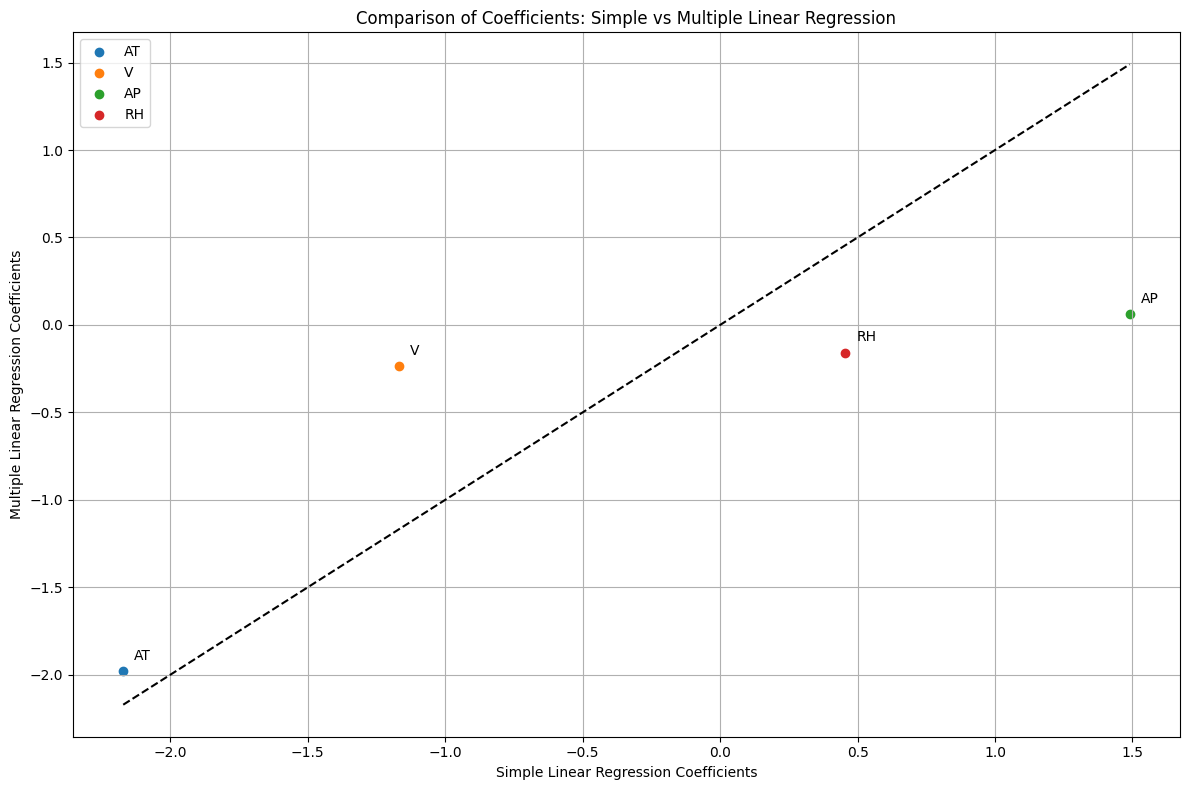

In [8]:
simple_coefficients = {}
simple_r2_val = {}

for predictor in predictors:
    model = LinearRegression()
    model.fit(data[[predictor]], data[response])
    simple_coefficients[predictor] = model.coef_[0]

    y_pred = model.predict(data[[predictor]])
    r2 = r2_score(data[response], y_pred)
    simple_r2_val[predictor] = r2

mult_model = LinearRegression()
mult_model.fit(data[predictors], data[response])
mult_coefficient = {}
for i, predictor in enumerate(predictors):
    mult_coefficient[predictor] = mult_model.coef_[i]

y_pred_mult = mult_model.predict(data[predictors])
r2_mult = r2_score(data[response], y_pred_mult)

print("Coefficient Comparison:")
print(f"{'Predictor':<15} {'Simple Coef':<20} {'Simple R2':<20} {'Mult Coef':<20} {'Change'}")
for predictor in predictors:
    simple_coef = simple_coefficients[predictor]
    mult_coef = mult_coefficient[predictor]
    change = mult_coef - simple_coef
    simple_r2 = simple_r2_val[predictor]

    print(f"{predictor:<15} {simple_coef:<20} {simple_r2:<20} {mult_coef:<20} {change}")

plt.figure(figsize=(12, 8))

simple_coefs = [simple_coefficients[p] for p in predictors]
mult_coefs = [mult_coefficient[p] for p in predictors]

for i, predictor in enumerate(predictors):
    plt.scatter(simple_coefs[i], mult_coefs[i], label=predictor, linewidths=1)

for i, predictor in enumerate(predictors):
    plt.annotate(predictor,
                 (simple_coefs[i], mult_coefs[i]),
                 xytext=(8, 8), textcoords='offset points')

min_coef = min(min(simple_coefs), min(mult_coefs))
max_coef = max(max(simple_coefs), max(mult_coefs))
plt.plot([min_coef, max_coef], [min_coef, max_coef], 'k--')

plt.xlabel('Simple Linear Regression Coefficients')
plt.ylabel('Multiple Linear Regression Coefficients')
plt.title('Comparison of Coefficients: Simple vs Multiple Linear Regression')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### (f) Nonlinear Association


AT:
Linear Model: R^2 = 0.8989, AIC = 59516.48
Polynomial Model: R^2 = 0.9119, AIC = 58209.95
Improvement in R^2: 0.0129
F-statistic: 701.9673, p-value: 1.1102e-16
Reject H0: Evidence of nonlinearity

V:
Linear Model: R^2 = 0.7565, AIC = 67930.62
Polynomial Model: R^2 = 0.7750, AIC = 67178.35
Improvement in R^2: 0.0185
F-statistic: 393.3141, p-value: 1.1102e-16
Reject H0: Evidence of nonlinearity

AP:
Linear Model: R^2 = 0.2688, AIC = 78452.42
Polynomial Model: R^2 = 0.2749, AIC = 78374.33
Improvement in R^2: 0.0061
F-statistic: 40.1961, p-value: 1.1102e-16
Reject H0: Evidence of nonlinearity

RH:
Linear Model: R^2 = 0.1519, AIC = 79870.61
Polynomial Model: R^2 = 0.1537, AIC = 79854.24
Improvement in R^2: 0.0018
F-statistic: 10.1889, p-value: 3.7996e-05
Reject H0: Evidence of nonlinearity


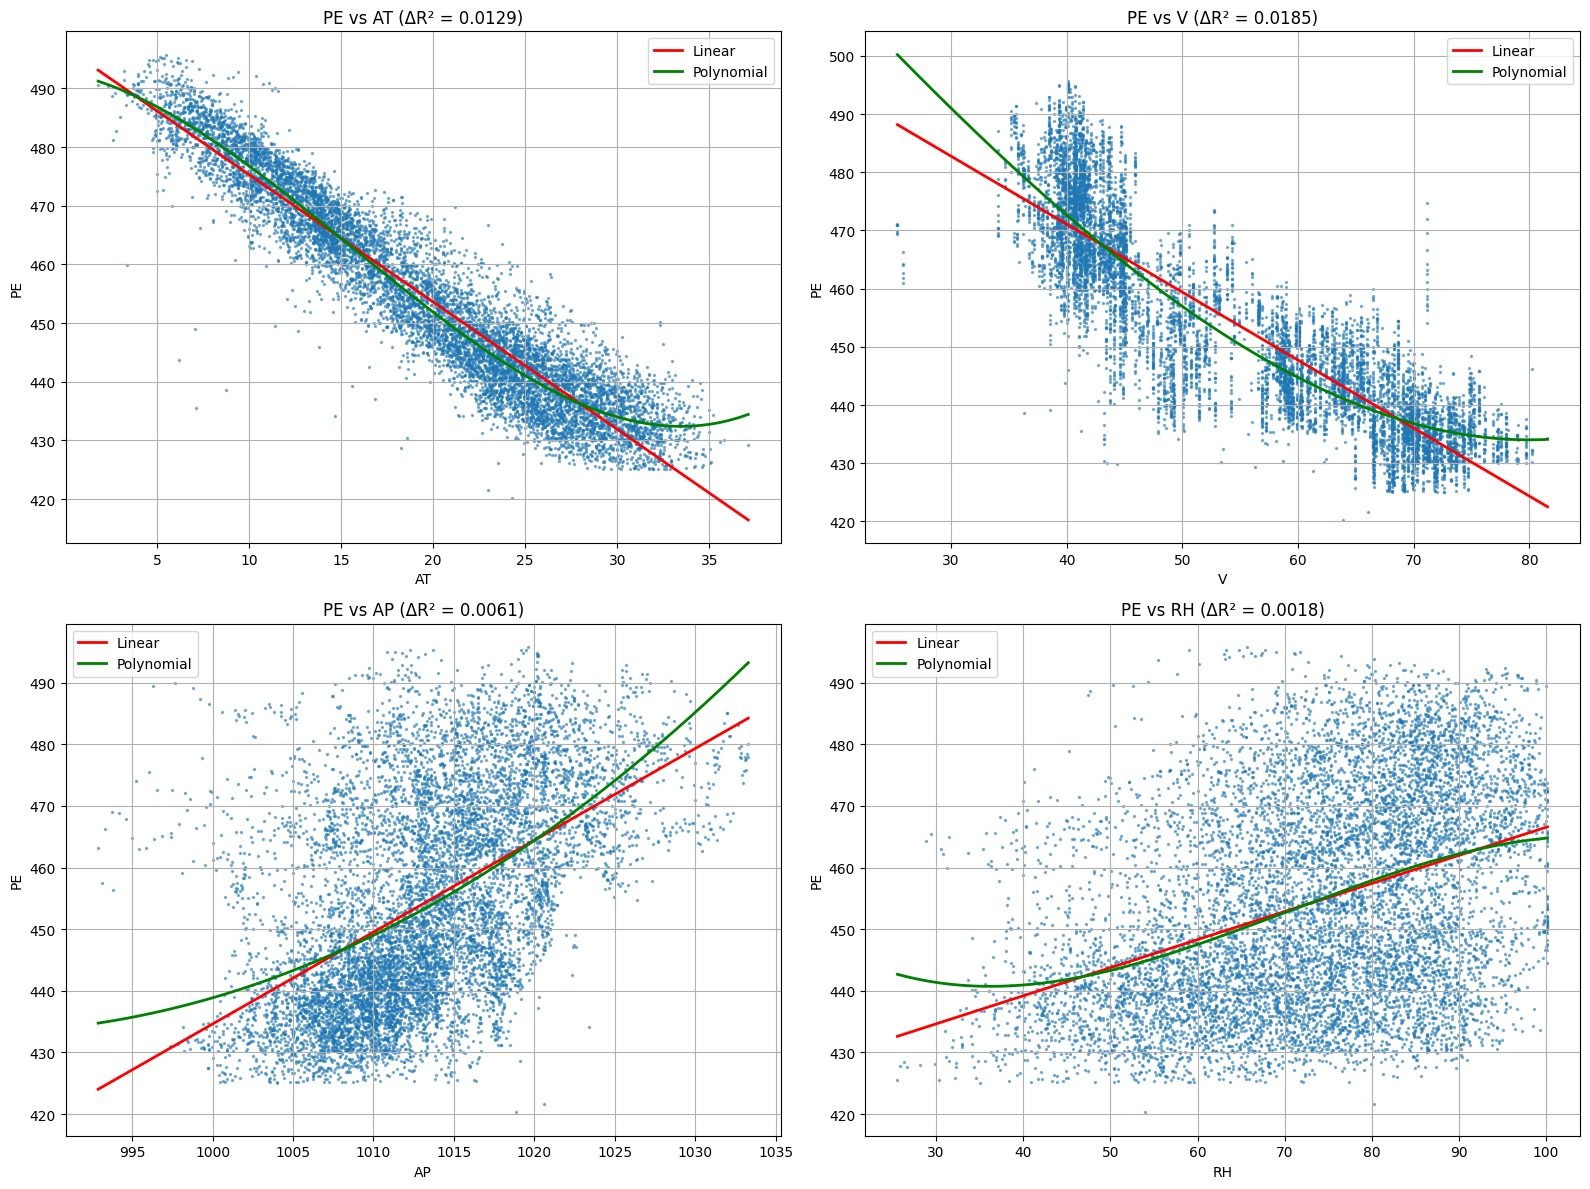

In [9]:
poly_res = {}
lin_res = {}

for predictor in predictors:
    x = data[predictor]
    y = data[response]

    x_lin = sm.add_constant(x)
    lin_model = sm.OLS(y, x_lin).fit()

    x_poly = pd.DataFrame({
        'const': 1,
        predictor: x,
        f'{predictor}_sq': x**2,
        f'{predictor}_cube': x**3 
    })

    poly_model = sm.OLS(y, x_poly).fit()
    lin_res[predictor] = lin_model
    poly_res[predictor] = poly_model

    print(f"\n{predictor}:")
    print(f"Linear Model: R^2 = {lin_model.rsquared:.4f}, AIC = {lin_model.aic:.2f}")
    print(f"Polynomial Model: R^2 = {poly_model.rsquared:.4f}, AIC = {poly_model.aic:.2f}")
    print(f"Improvement in R^2: {poly_model.rsquared - lin_model.rsquared:.4f}")

    ssr_lin = lin_model.ssr
    ssr_poly = poly_model.ssr
    f_stat = ((ssr_lin - ssr_poly) / 2) / (ssr_poly / poly_model.df_resid)
    f_p_value = 1 - stats.f.cdf(f_stat, 2, poly_model.df_resid)

    print(f"F-statistic: {f_stat:.4f}, p-value: {f_p_value:.4e}")
    if f_p_value < 0.05:  # Statistically significant
        print("Reject H0: Evidence of nonlinearity")
    else:
        print("Fail to reject H0: No evidence of nonlinearity")


fig, axes = plt.subplots(2, 2, figsize = (16, 12))

for i, predictor in enumerate(predictors):
    row = i // 2
    col = i % 2
    ax = axes[row, col]

    x_val = data[predictor]
    y_val = data[response]

    ax.scatter(x_val, y_val, alpha=0.5, s=2)
    x_range = np.linspace(x_val.min(), x_val.max(), 300)

    x_lin_pred = sm.add_constant(x_range)
    lin_pred = lin_res[predictor].predict(x_lin_pred)

    x_poly = pd.DataFrame({
        'const': 1,
        predictor: x_range,
        f'{predictor}_sq': x_range**2,
        f'{predictor}_cube': x_range**3
    })
    poly_pred = poly_res[predictor].predict(x_poly)

    ax.plot(x_range, lin_pred, color='red', label='Linear', linewidth=2)
    ax.plot(x_range, poly_pred, color='green', label='Polynomial', linewidth=2)

    delta_r2 = poly_res[predictor].rsquared - lin_res[predictor].rsquared
    ax.set_title(f'{response} vs {predictor} (ΔR² = {delta_r2:.4f})')
    ax.set_xlabel(predictor)
    ax.set_ylabel(response)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


### (g) Interactions of Predictors

In [10]:
x_main = data[predictors]
x_main_with_const = sm.add_constant(x_main)
y_main = data[response]

interaction_data = x_main.copy()
interaction_terms = []

for pred1, pred2 in combinations(predictors, 2):
    interaction_col = f'{pred1}*{pred2}'
    interaction_data[interaction_col] = x_main[pred1] * x_main[pred2]
    interaction_terms.append(interaction_col)
    print(f" {interaction_col}")

x_full_const = sm.add_constant(interaction_data)
full_interaction_model = sm.OLS(y_main, x_full_const).fit()
print(full_interaction_model.summary())

print(f"{'Model':<20} {'R^2':>8} {'AIC':>10} {'BIC':>8} {'Parameters'}")
print("-" * 70)
print(f"{'Main Effects':<25} {model_sm.rsquared:.4f} {model_sm.aic:.2f} {model_sm.bic:.2f} {len(model_sm.params)}")
print(f"{'Full Interaction':<25} {full_interaction_model.rsquared:.4f} {full_interaction_model.aic:.2f} {full_interaction_model.bic:.2f} {len(full_interaction_model.params)}")

ssr_main = model_sm.ssr
ssr_full = full_interaction_model.ssr
df_diff = len(interaction_terms)
df_resid = full_interaction_model.df_resid

f_stat = ((ssr_main - ssr_full) / df_diff) / (ssr_full / df_resid)
f_p_value = 1 - stats.f.cdf(f_stat, df_diff, df_resid)

print(f"F-statistic: {f_stat:.4f}, p-value: {f_p_value:.4e}")
if f_p_value < 0.05:
    print("Reject H0: Interaction are statistically significant")
else:
    print("Fail to reject H0: Interactions are not statistically significant")

 AT*V
 AT*AP
 AT*RH
 V*AP
 V*RH
 AP*RH
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Wed, 24 Sep 2025   Prob (F-statistic):               0.00
Time:                        15:58:21   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

### (h) Improvement

In [11]:
np.random.seed(42)

x = data[predictors]
y = data[response]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(x_train)}")
print(f"Test set size: {len(x_test)}")
print()

print("Basic Linear Model:")

x_train_const = sm.add_constant(x_train)
model = sm.OLS(y_train, x_train_const).fit()

print(f"R2 = {model.rsquared:.4f}")
print("Adjusted R2:", model.rsquared_adj)
print(f"AIC = {model.aic:.2f}")

y_train_pred = model.predict(x_train_const)
x_test_const = sm.add_constant(x_test)
y_test_pred = model.predict(x_test_const)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print()

print("Full model with interactions:")

train_data = x_train.copy()

quadratic_terms = []
for predictor in predictors:
    quad_name = f"{predictor}_sq"
    train_data[quad_name] = x_train[predictor] ** 2
    quadratic_terms.append(quad_name)

interaction_terms = []
for pred1, pred2 in combinations(predictors, 2):
    inter_name = f"{pred1}*{pred2}"
    train_data[inter_name] = x_train[pred1] * x_train[pred2]
    interaction_terms.append(inter_name) 

print(f"Quadratic terms: {quadratic_terms}")
print(f"Interaction terms: {interaction_terms}")
print(f"Total features: {len(train_data.columns)}")
print()

x_train_full_const = sm.add_constant(train_data)
full_model = sm.OLS(y_train, x_train_full_const).fit()

print(f"R2 = {full_model.rsquared:.4f}")
print("Adjusted R2:", full_model.rsquared_adj)
print(f"AIC = {full_model.aic:.2f}")
print()

print("Variable Selection")
significant_terms = []
p_value_threshold = 0.05

print(f"{'Variable':<15} {'Coefficient':>12} {'p-value':>12}")

for var in full_model.params.index:
    if var != 'const':
        p_val = full_model.pvalues[var]
        coef = full_model.params[var]
        is_sig = p_val < p_value_threshold

        print(f"{var:<15} {coef:>12.4f} {p_val:>12.4e}")
        
        if is_sig:
            significant_terms.append(var)

print("Reduced Model:")

train_data_reduced = train_data[significant_terms]
x_train_reduced_const = sm.add_constant(train_data_reduced)

reduced_model = sm.OLS(y_train, x_train_reduced_const).fit()
print(f"R2 = {reduced_model.rsquared:.4f}")
print("Adjusted R2:", reduced_model.rsquared_adj)   
print(f"AIC = {reduced_model.aic:.2f}")
print(f"parameters: {len(reduced_model.params)}")
print()

test_data = x_test.copy()

for predictor in predictors:
    quad_name = f"{predictor}_sq"
    test_data[quad_name] = x_test[predictor] ** 2

for pred1, pred2 in combinations(predictors, 2):
    inter_name = f"{pred1}*{pred2}"
    test_data[inter_name] = x_test[pred1] * x_test[pred2]

x_test_full_const = sm.add_constant(test_data)
y_test_pred_full = full_model.predict(x_test_full_const)

test_data_reduced = test_data[significant_terms]
x_test_reduced_const = sm.add_constant(test_data_reduced)
y_test_pred_reduced = reduced_model.predict(x_test_reduced_const)

y_train_pred_full = full_model.predict(x_train_full_const)
y_train_pred_reduced = reduced_model.predict(x_train_reduced_const)

train_mse_full = mean_squared_error(y_train, y_train_pred_full)
train_mse_reduced = mean_squared_error(y_train, y_train_pred_reduced)

print(f"{'Model':<20} {'Train MSE':>12} {'Test MSE':>12} {'R2 Train':>10} {'Parameters'}")
print(f"{'Basic Linear Model':<25} {train_mse:<12.4f} {test_mse:<10.4f} {model.rsquared:<15.4f} {len(model.params)}")
print(f"{'Full Interaction Model':<25} {train_mse_full:<12.4f} {mean_squared_error(y_test, y_test_pred_full):<10.4f} {full_model.rsquared:<15.4f} {len(full_model.params)}")
print(f"{'Reduced Interaction Model':<25} {train_mse_reduced:<12.4f} {mean_squared_error(y_test, y_test_pred_reduced):<10.4f} {reduced_model.rsquared:<15.4f} {len(reduced_model.params)}")


Training set size: 7654
Test set size: 1914

Basic Linear Model:
R2 = 0.9283
Adjusted R2: 0.9282940669649665
AIC = 44994.94
Train MSE: 20.8934
Test MSE: 20.2737

Full model with interactions:
Quadratic terms: ['AT_sq', 'V_sq', 'AP_sq', 'RH_sq']
Interaction terms: ['AT*V', 'AT*AP', 'AT*RH', 'V*AP', 'V*RH', 'AP*RH']
Total features: 14

R2 = 0.9377
Adjusted R2: 0.9375950665549423
AIC = 43941.56

Variable Selection
Variable         Coefficient      p-value
AT                   -5.8537   9.0560e-02
V                    -2.7497   1.0113e-01
AP                   15.4112   5.6121e-09
RH                    3.9526   5.5162e-05
AT_sq                 0.0180   2.4261e-07
V_sq                 -0.0006   4.9451e-01
AP_sq                -0.0075   4.9809e-09
RH_sq                -0.0019   8.6513e-11
AT*V                  0.0104   6.6737e-04
AT*AP                 0.0031   3.4941e-01
AT*RH                -0.0055   1.0074e-03
V*AP                  0.0023   1.6318e-01
V*RH                  0.0001   9.2761e-

### (i) KNN

Raw Means: [  19.62   54.26 1013.25   73.34]
Raw Stds: [ 7.43 12.71  5.95 14.62]
Scaled Means: [-0. -0. -0.  0.]
Scaled Stds: [1. 1. 1. 1.]
20 40 60 80 100 
Best Raw K: 6 with Test MSE: 15.1308 and Train MSE: 11.0656
Best Scaled K: 4 with Test MSE: 13.7134 and Train MSE: 8.3564


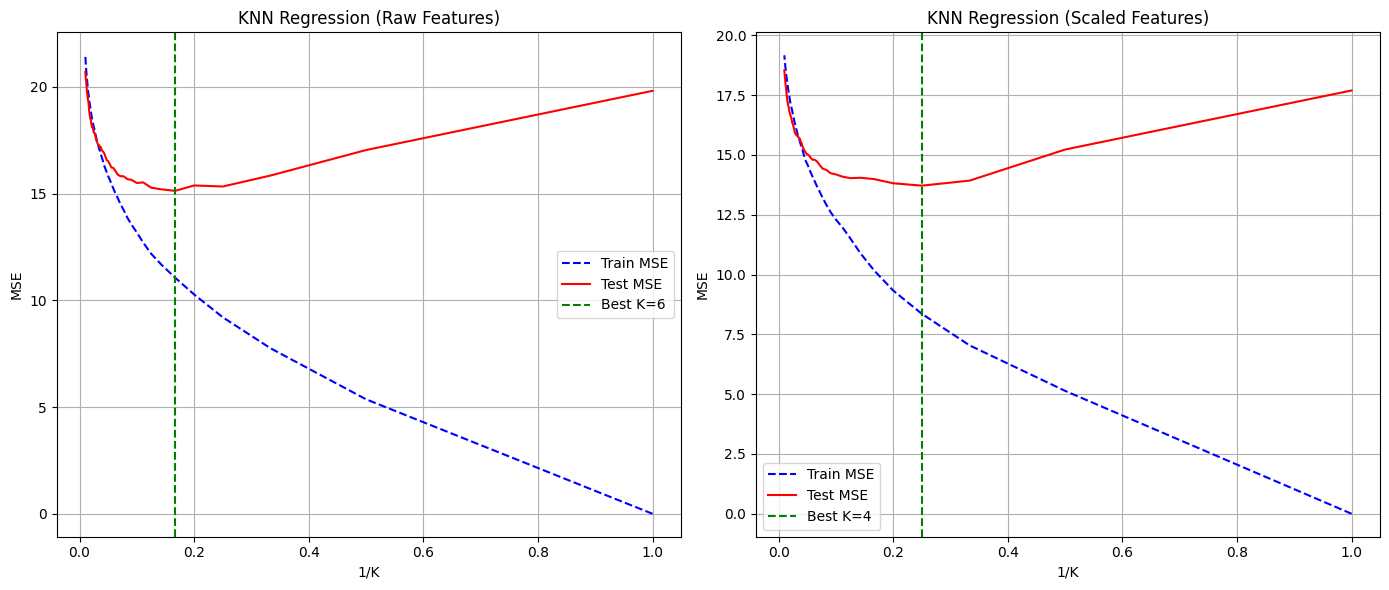

In [91]:
np.random.seed(42)
x = data[predictors]
y = data[response]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train_raw = x_train.values
x_test_raw = x_test.values

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print("Raw Means:", x_train.mean().round(2).values)
print("Raw Stds:", x_train.std().round(2).values)
print("Scaled Means:", x_train_scaled.mean(axis=0).round(3))
print("Scaled Stds:", x_train_scaled.std(axis=0).round(3))

k_val = list(range(1, 101))
k_inv = [1/k for k in k_val]

res_raw = {'k': k_val, '1/k': k_inv, 'Train MSE': [], 'Test MSE': []}
res_scaled = {'k': k_val, '1/k': k_inv, 'Train MSE': [], 'Test MSE': []}

for i, k in enumerate(k_val):
    if (i + 1) % 20 == 0:
        print(f"{i + 1}", end=' ', flush=True)

    knn_raw = KNeighborsRegressor(n_neighbors=k)
    knn_raw.fit(x_train_raw, y_train)

    y_train_pred_raw = knn_raw.predict(x_train_raw)
    y_test_pred_raw = knn_raw.predict(x_test_raw)

    train_mse_raw = mean_squared_error(y_train, y_train_pred_raw)
    test_mse_raw = mean_squared_error(y_test, y_test_pred_raw)

    res_raw['Train MSE'].append(train_mse_raw)
    res_raw['Test MSE'].append(test_mse_raw)

    knn_scaled = KNeighborsRegressor(n_neighbors=k)
    knn_scaled.fit(x_train_scaled, y_train)

    y_train_pred_scaled = knn_scaled.predict(x_train_scaled)
    y_test_pred_scaled = knn_scaled.predict(x_test_scaled)

    train_mse_scaled = mean_squared_error(y_train, y_train_pred_scaled)
    test_mse_scaled = mean_squared_error(y_test, y_test_pred_scaled)

    res_scaled['Train MSE'].append(train_mse_scaled)
    res_scaled['Test MSE'].append(test_mse_scaled)

best_k_raw_idx = np.argmin(res_raw['Test MSE'])
best_k_raw = k_val[best_k_raw_idx]
best_test_mse_raw = res_raw['Test MSE'][best_k_raw_idx]
best_train_mse_raw = res_raw['Train MSE'][best_k_raw_idx]

best_k_scaled_idx = np.argmin(res_scaled['Test MSE'])
best_k_scaled = k_val[best_k_scaled_idx]
best_test_mse_scaled = res_scaled['Test MSE'][best_k_scaled_idx]
best_train_mse_scaled = res_scaled['Train MSE'][best_k_scaled_idx]

print(f"\nBest Raw K: {best_k_raw} with Test MSE: {best_test_mse_raw:.4f} and Train MSE: {best_train_mse_raw:.4f}")
print(f"Best Scaled K: {best_k_scaled} with Test MSE: {best_test_mse_scaled:.4f} and Train MSE: {best_train_mse_scaled:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(k_inv, res_raw['Train MSE'], 'b--', label='Train MSE')
ax1.plot(k_inv, res_raw['Test MSE'], 'r-', label='Test MSE')
ax1.axvline(x=1/best_k_raw, color='green', linestyle='--', label=f'Best K={best_k_raw}')
ax1.set_xlabel('1/K')
ax1.set_ylabel('MSE')
ax1.set_title('KNN Regression (Raw Features)')
ax1.legend()
ax1.grid(True)

ax2.plot(k_inv, res_scaled['Train MSE'], 'b--', label='Train MSE')
ax2.plot(k_inv, res_scaled['Test MSE'], 'r-', label='Test MSE')
ax2.axvline(x=1/best_k_scaled, color='green', linestyle='--', label=f'Best K={best_k_scaled}')
ax2.set_xlabel('1/K')
ax2.set_ylabel('MSE')
ax2.set_title('KNN Regression (Scaled Features)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


### (j ) Compare KNN and Linear

In [105]:
lin_res = {
    'Basic Linear': {'Train MSE': 20.8934, 'Test MSE': 20.2737, 'r2': 0.9283, 'parameters': 5 },
    'Full Interaction': {'Train MSE': 18.1595, 'Test MSE': 17.9031, 'r2': 0.9377, 'parameters': 15 },
    'Reduced Interaction': {'Train MSE': 20.2685, 'Test MSE': 19.8439, 'r2': 0.9305, 'parameters': 9 }
}

best_lin_name = min(lin_res.keys(), key=lambda x: lin_res[x]['Test MSE'])
best_lin = lin_res[best_lin_name]

for name, res in lin_res.items():
    print(f"{name}: Train MSE = {res['Train MSE']:.4f}, Test MSE = {res['Test MSE']:.4f}")

print(f"Raw KNN Best: K = {best_k_raw}, Train MSE = {best_train_mse_raw:.4f}, Test MSE = {best_test_mse_raw:.4f}")
print(f"Scaled KNN Best: K = {best_k_scaled}, Train MSE = {best_train_mse_scaled:.4f}, Test MSE = {best_test_mse_scaled:.4f}")

best_knn_test_mse = min(best_test_mse_raw, best_test_mse_scaled)
best_knn_approach = "Scaled" if best_test_mse_scaled < best_test_mse_raw else "Raw"
best_knn_k = best_k_scaled if best_knn_approach == "Scaled" else best_k_raw

print(f"Best Linear Model: {best_lin_name} with Test MSE = {best_lin['Test MSE']:.4f}")
print(f"Best KNN Model: {best_knn_approach} KNN with K = {best_knn_k} and Test MSE = {best_knn_test_mse:.4f}")

if best_knn_test_mse < best_lin['Test MSE']:
    improvement = ((best_lin['Test MSE'] - best_knn_test_mse) / best_lin['Test MSE']) * 100
    print(f"KNN outperforms Linear Regression by {improvement:.2f}% in Test MSE")
else:
    improvement = ((best_knn_test_mse - best_lin['Test MSE']) / best_knn_test_mse) * 100
    print(f"Linear Regression outperforms KNN by {improvement:.2f}% in Test MSE")
print("Power plant data has strong nonlinear patterns")

Basic Linear: Train MSE = 20.8934, Test MSE = 20.2737
Full Interaction: Train MSE = 18.1595, Test MSE = 17.9031
Reduced Interaction: Train MSE = 20.2685, Test MSE = 19.8439
Raw KNN Best: K = 6, Train MSE = 11.0656, Test MSE = 15.1308
Scaled KNN Best: K = 4, Train MSE = 8.3564, Test MSE = 13.7134
Best Linear Model: Full Interaction with Test MSE = 17.9031
Best KNN Model: Scaled KNN with K = 4 and Test MSE = 13.7134
KNN outperforms Linear Regression by 23.40% in Test MSE
Power plant data has strong nonlinear patterns


## 2. ISLR: 2.4.1

### (a) The sample size n is extremely large, and the number of predictors p is small.

Flexible statistical learning would be better than inflexible statistical learning, because the sample size is extremely large, and flexible statistical learning is typicaly better when working with large sample sizes and can model more complicated patters in the data.

### (b) The number of predictors p is extremely large, and the number of observations n is small.

Flexible statistical learning would be worse than inflexible statistical learning, because with a large predictor and a small n, flexible learning will overfit with high variance.

### (c) The relationship between the predictors and response is highly non-linear.

Flexible statistical learning would be better since they are typically designed to model non-linear and complex patterns.

### (d) The variance of the error terms, i.e. $σ^2$ = Var(ε), is extremely high.

Flexible statistical learning would be worse because with a high high error term will have an increase in variance.

## 3. ISLR: 2.4.7

### (a) Compute the Euclidean distance between each observation and the test point, X1 = X2 = X3 = 0.

In [35]:
from IPython.display import display, Math

display(Math(r"d = \sqrt((X_1-0)^2 + (X_2-0)^2 + (X_3 - 0)^2)"))
print("Obs 1:")
display(Math(r"\sqrt(0^2 + 3^2 + 0^2) = 3"))
print("Obs 2:")
display(Math(r"\sqrt(2^2 + 0^2 + 0^2) = 2"))
print("Obs 3:")
display(Math(r"\sqrt(0^2 + 1^2 + 3^2) = \sqrt10 = 3.162"))
print("Obs 4:")
display(Math(r"\sqrt(0^2 + 1^2 + 2^2) = \sqrt5 = 2.236"))
print("Obs 5:")
display(Math(r"\sqrt(-1^2 + 0^2 + 1^2) = \sqrt2 = 1.414"))
print("Obs 6:")
display(Math(r"\sqrt(1^2 + 1^2 + 1^2) = \sqrt3 = 1.732"))

<IPython.core.display.Math object>

Obs 1:


<IPython.core.display.Math object>

Obs 2:


<IPython.core.display.Math object>

Obs 3:


<IPython.core.display.Math object>

Obs 4:


<IPython.core.display.Math object>

Obs 5:


<IPython.core.display.Math object>

Obs 6:


<IPython.core.display.Math object>

### (b) What is our prediction with K = 1? Why?

Obs 5 is the closest class for K = 1, therefore Obs 5 is the nearest neighbor with the prediction as Green.

### (c) What is our prediction with K = 3? Why?

Obs 5, Obs 6, and Obs 2 are the 3 nearest neighbors. The classes for these Obs are Green, Red, and Red. Since there are 2 Reds, the prediction would be Red.

### (d) If the Bayes decision boundary in this problem is highly non-linear, then would we expect the best value for K to be large or small? Why?

We would expect the best value for K to be small, because a small K would make the decision boundary more flexible and better able to capture the non-linear patterns in the data. With a small K, there can be a lower bias and higher variance, which is good for complex decision boundaries.